In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import datetime

from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-09-22 19:21:22.845686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758568883.217122      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758568883.314667      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# import tensorflow as tf

# # Connect to TPU
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.TPUStrategy(tpu)
#     print("TPU initialized")
# except:
#     print("TPU not found")
# print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TPU not found
Num GPUs Available: 2


In [3]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()
    ax1.plot(history['loss'], label='Training loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.legend()

    ax2.set_title('Accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax2.grid()
    ax2.plot(history['accuracy'], label='Training accuracy')
    ax2.plot(history['val_accuracy'], label='Validation accuracy')
    ax2.legend()

    plt.show()

In [4]:
for folder in [d for d in os.listdir('/kaggle/input/animalprediction/mg-animal-prediction-25-26')]:
    print(folder)

train_images
Ejemplo submission - final_predictions.csv
test_images


## Analyze images and format

cavallo : (300, 225, 3)
n_images = 2123


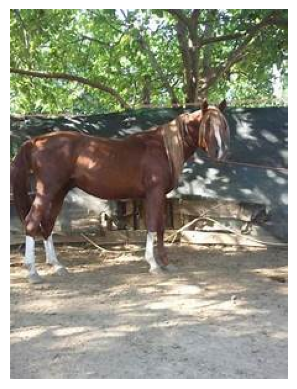

pecora : (201, 300, 3)
n_images = 1320


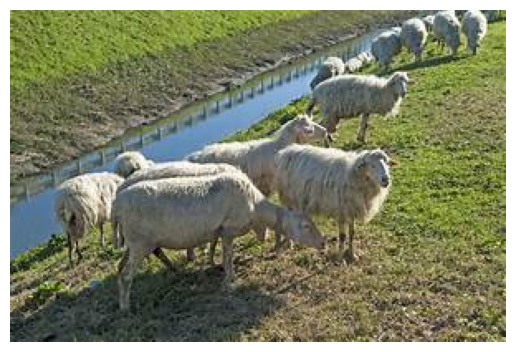

elefante : (225, 300, 3)
n_images = 946


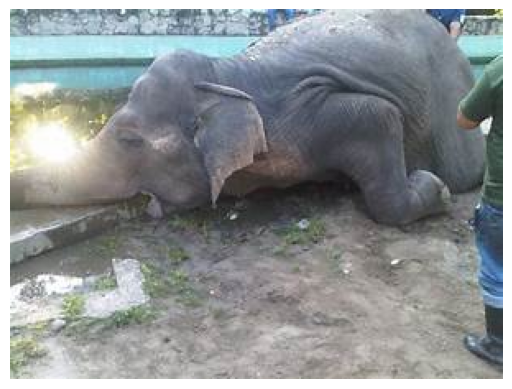

gatto : (225, 300, 3)
n_images = 1168


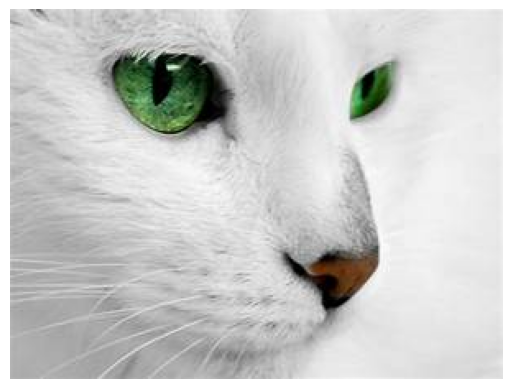

scoiattolo : (300, 174, 3)
n_images = 1362


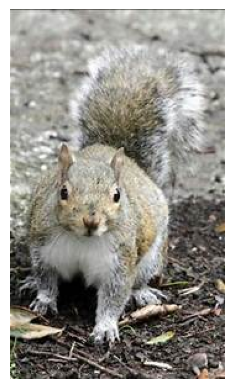

gallina : (300, 283, 3)
n_images = 2598


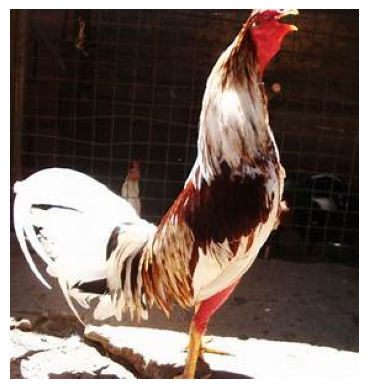

ragno : (293, 300, 3)
n_images = 4321


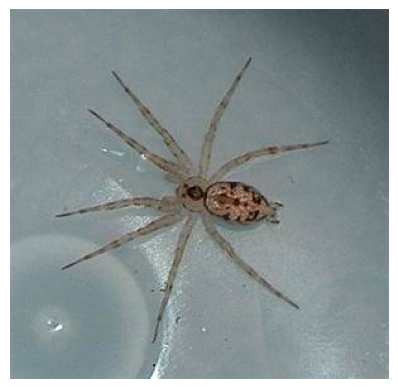

mucca : (214, 300, 3)
n_images = 1366


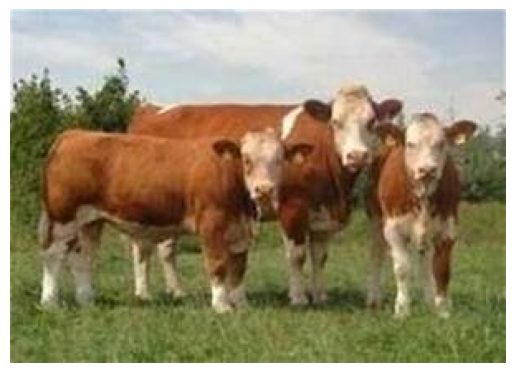

cane : (254, 300, 3)
n_images = 4363


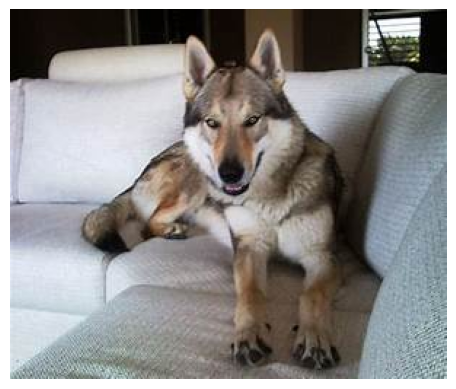

farfalla : (258, 300, 3)
n_images = 1612


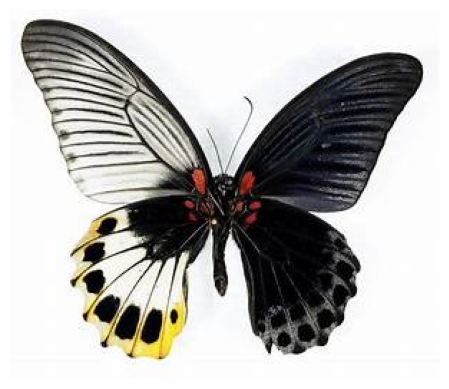

num_samples = 21179
num_validation_samples = 4235
num_train_samples = 16944
num_categories = 10


In [5]:
data_dir = '/kaggle/input/animalprediction/mg-animal-prediction-25-26/train_images'

num_samples = 0
num_categories = 0
# For each category, we:
# - Count it and the number of images in it
# - Plot the first image and print its size
# Finally we print the number of images inside each group
for folder in [d for d in os.listdir(data_dir)]:
    n_images = sum(1 for _ in os.listdir(data_dir + '/' + folder))
    num_samples += n_images
    num_categories += 1
    img = cv2.imread(data_dir + '/' + folder + '/' + os.listdir(data_dir + '/' + folder)[0])

    
    print(folder , ':', end=' ')
    print(img.shape)
    print(f"{n_images = }")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
print(f"{num_samples = }")
num_validation_samples = int(num_samples *0.2)
num_train_samples = num_samples - num_validation_samples
print(f"{num_validation_samples = }")
print(f"{num_train_samples = }")
print(f"{num_categories = }")

Each image has different size and shape, so we'll have to reshape them (`target_size` in `datagen.flow_from_directory`)

## Under and oversampling

In [6]:
'''import os
import random
from shutil import copy2, rmtree
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img

# Paths
input_dir = 'train_data'
output_dir = 'balanced_train_data'
target_count = 2000

# Augmentation setup
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create output directory
if os.path.exists(output_dir):
    rmtree(output_dir)
os.makedirs(output_dir)

# Process each category
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if not os.path.isdir(category_path):
        continue

    images = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    count = len(images)
    output_category_path = os.path.join(output_dir, category)
    os.makedirs(output_category_path)

    # Undersample
    if count > target_count:
        selected = random.sample(images, target_count)
        for img_name in selected:
            copy2(os.path.join(category_path, img_name), output_category_path)

    # Oversample
    else:
        for img_name in images:
            copy2(os.path.join(category_path, img_name), output_category_path)

        i = 0
        while len(os.listdir(output_category_path)) < target_count:
            img_path = os.path.join(category_path, random.choice(images))
            img = load_img(img_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            for batch in datagen.flow(x, batch_size=1):
                save_img(os.path.join(output_category_path, f'aug_{i}.jpg'), batch[0])
                i += 1
                break  # Only one image per loop
'''
print()

In [7]:
print(os.listdir('./models'))

['Initial_HelloWorld_09_22_14:24.h5', 'Initial_HelloWorld_09_22_14:25.h5', 'Initial_HelloWorld_09_22_17:29.keras']


## Define hyperparameters

In [8]:
target_size = (128,128)
batch_size = 128

## For model save
family = "Initial"
name = "HelloWorld"
model_path = None

## Create Image Generators to provide images to the model
We include data augmentation by rotating, shifting, zooming and flipping to add more generalization.

In [9]:
# We create a generator to enrich data
datagen = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.5,  # 20% for validation
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 10591 images belonging to 10 classes.
Found 10588 images belonging to 10 classes.


In [10]:
def create_classifier():
    input = Input(shape=(target_size[0], target_size[1], 3))
    x = Conv2D(32, 3, activation='relu')(input)
    x = Conv2D(64, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, 3, activation='relu')(x)
    x = Conv2D(128, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, 3, activation='relu')(x)
    x = Conv2D(256, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation="relu")(x)
    
    output = Dense(num_categories, activation="softmax")(x)
    return Model(input, output)

Not good.

Change the architecturen rethink it

Maybe you need to oversample some categories

In [11]:
# Create Model
if not model_path:
    model = create_classifier()
# Load the model
else:
    model = keras.models.load_model('model_path')
model.summary()

I0000 00:00:1758568920.836566      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758568920.837219      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 124, 124, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 58, 58, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,046,346 (38.32 MB)

 Trainable params: 10,045,450 (38.32 MB)

 Non-trainable params: 896 (3.50 KB)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Train

In [ ]:
history = model.fit(
train_generator,
steps_per_epoch = train_generator.samples // train_generator.batch_size,
epochs = 20,
validation_data = validation_generator,
validation_steps = validation_generator.samples // validation_generator.batch_size,
verbose = 1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1758568932.668163     117 service.cc:148] XLA service 0x7bbd2c017820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758568932.669702     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758568932.669724     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758568933.437120     117 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758568954.811282     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1934 - loss: 5.8865

In [ ]:
plot_losses(history.history)

### Second training

In [ ]:
history = model.fit(
train_generator,
steps_per_epoch = train_generator.samples // train_generator.batch_size,
epochs = 20,
validation_data = validation_generator,
validation_steps = validation_generator.samples // validation_generator.batch_size,
verbose = 1)

In [ ]:
plot_losses(history.history)

In [ ]:
# Current timestamp
timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
## Make sure everything saves correctly
os.makedirs("models", exist_ok=True)
try:
    family = family
except:
    family= "generic"
try:
    name = name
except:
    name= "model"
model_path = f"models/{family}_{name}_{timestamp}.keras"

# Save the model
model.save(model_path)